In [45]:
import warnings
warnings.filterwarnings('ignore')
import pickle5 as pickle

In [46]:
%reload_ext autoreload
%autoreload 2

In [47]:
import numpy as np
import model
import plotly.express as px
import pandas as pd
%matplotlib inline
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [48]:
def unemployment(workers):
    return 1-(sum(workers)/number_of_householders)

def monopoly(workers):
    median = np.median(workers)
    if median < 1:
        median = 1
    monopolist = max(workers)
    return monopolist/median

In [49]:
research_variables = ['lambda_coefficient','prob_search_price','gamma']
problem = {
    'num_vars': len(research_variables),
    'names': research_variables,
    'bounds': [[2, 6],[0.1, 0.5],[8, 20]]
}

In [ ]:
#model_reporters = {"Wolves": lambda m: m.schedule.get_breed_count(Wolf),
#             "Sheep": lambda m: m.schedule.get_breed_count(Sheep)}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
number_of_householders = 200
number_of_companies = 30

number_of_days = 3000

replicates = 1
distinct_samples = 300

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)),
                                columns=research_variables)
data['Run'], data['unemployment'], data['monopoly'] = None, None, None
arr = pd.DataFrame()

for i in range(replicates):
    for vals in param_values:
        # Change parameters that should be integers
        #vals = list(vals)
        vals[0] = int(vals[0])
        vals[2] = int(vals[2])
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        
        #print(variable_parameters['lambda_coefficient'],variable_parameters['prob_search_price'])
        current_run = model.run_model(number_of_householders, number_of_companies, number_of_days,
                                      lambda_coefficient=int(variable_parameters['lambda_coefficient']),
                                      prob_search_price=variable_parameters['prob_search_price'],
                                      gamma=variable_parameters['gamma'],
                                      use_network=False, use_marketing=False)
        #batch.run_iteration(variable_parameters, tuple(vals), count)
        run_data = current_run.datacollector.get_model_vars_dataframe()
        month_in_run = run_data.shape[0]
        iteration_data = run_data.iloc[month_in_run - 1]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
        data.iloc[count, 0:3] = vals
        #data.iloc[count, 3:6] = iteration_data
        tmp = current_run.datacollector.get_model_vars_dataframe()[['households']]
        tmp['unemployment'] = tmp.households.apply(unemployment)
        tmp['monopoly'] = tmp.households.apply(monopoly)
        kek = pd.DataFrame([count, tmp['unemployment'][len(tmp)-1], tmp['monopoly'][len(tmp)-1]],
                           index=['Run', 'unemployment', 'monopoly'])
        data.iloc[count, len(research_variables):len(research_variables)+3] = kek[0]
        count += 1

        #clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
        #break
    #break

data.to_pickle('basic_results_1.pkl')
#df = pd.read_pickle(file_name)

In [56]:
file_name = 'basic_results_'
path = './results/'
number_of_dataframes = 20

with open(path + file_name + '1.pkl', "rb") as pickle_in:
    data = pickle.load(pickle_in)

for i in range(number_of_dataframes):
    with open(path + file_name + str(i+1) + '.pkl', "rb") as pickle_in:
        data_new = pickle.load(pickle_in)
    data = pd.concat([data, data_new])

In [52]:
Si_unemployment = sobol.analyze(problem, data['unemployment'].values, print_to_console=True)
print("--")
Si_monopoly = sobol.analyze(problem, data['monopoly'].values, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
lambda_coefficient 0.688265 0.032862 0.952501 0.034209
prob_search_price 0.001699 0.019409 0.284920 0.019939
gamma -0.000076 0.018787 0.279087 0.018410

Parameter_1 Parameter_2 S2 S2_conf
lambda_coefficient prob_search_price -0.004410 0.039096
lambda_coefficient gamma 0.014345 0.040751
prob_search_price gamma 0.000441 0.025005
--
Parameter S1 S1_conf ST ST_conf
lambda_coefficient 0.538385 0.031308 0.925748 0.033684
prob_search_price -0.018202 0.022117 0.402461 0.018257
gamma -0.007010 0.021843 0.395897 0.018692

Parameter_1 Parameter_2 S2 S2_conf
lambda_coefficient prob_search_price 0.011662 0.045010
lambda_coefficient gamma 0.017939 0.042130
prob_search_price gamma 0.002225 0.031215


In [53]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

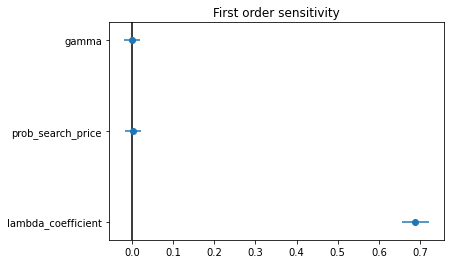

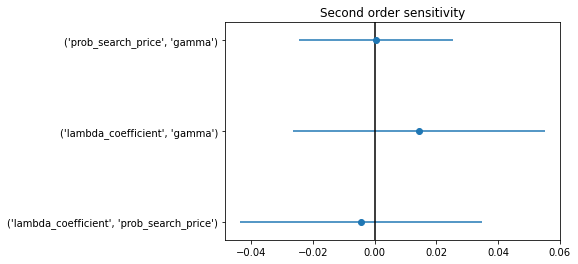

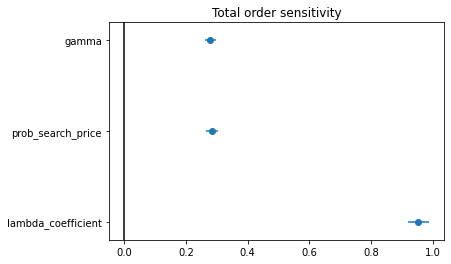

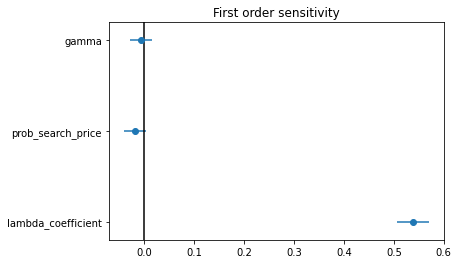

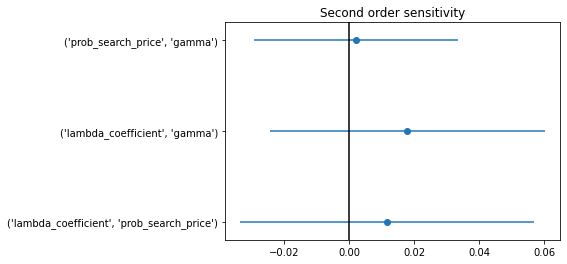

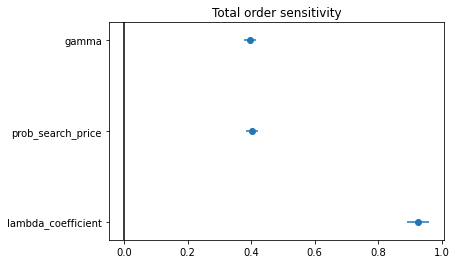

In [54]:
for Si in (Si_unemployment, Si_monopoly):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Second order
    plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()